# Neural Networks

#### Author
> Zulker Nayeen Nahiyan  
> Major in Computer Science  
> Independent University, Bangladesh

Much of this work was done as part of a university course at IUB.

#### Course
> CSC 424, Section 1, Spring 2022  
> Dr. A.K.M. Mahbubur Rahman  
> Department of Computer Science & Engineering  
> Independent University, Bangladesh

#### Instructions:
> - **Google Colaboratory:**
>   - Go to `Runtime -> Change runtime type`, and then set the `Hardware Accelerator` to `GPU`.
>   - Set `GPU_ACCELERATED = True` in the first code block.
> - **Jupyter:**
>   - Find out the current CUDA version by running: `nvcc --version` 
>   - Install the `cupy-cudaXXY` package through pip, where `XX.Y` matches the current CUDA version: `pip install cupy-cudaXXY`
>   - Set `GPU_ACCELERATED = True` in the first code block.

# 1. Concepts

## 1.1. Dependencies

The assignment depends on the following scientific packages:

- Computation:
    - `numpy`: Handling large arrays of numbers and performing operations on them.
    - `cupy`: GPU-accelerated substitute for `numpy` powered by CUDA.
- Datasets:
    - `sklearn`: Generating the Moons dataset and calculating metrics for performance evaluation.
    - `tensorflow`: Importing the CIFAR-10 dataset.
- Plotting:
    - `matplotlib`: Plotting the Moons dataset in a 2D chart.
    - `plotly`: Plotting the model surface in a 3D chart.



In [ ]:
%pip install --quiet numpy matplotlib sklearn tensorflow keras plotly nbformat

# GPU acceleration. (Note: Google Colaboratory supports CUDA 11.1 as of March 2022.)
!nvcc --version
%pip install --quiet cupy-cuda111

In [43]:
from abc import ABC, abstractmethod
from contextlib import contextmanager
from dataclasses import dataclass, field
from enum import Enum
from itertools import tee
from math import isclose
from time import time
from typing import Any, Callable, Optional, Union, List, Tuple, Dict, Iterator

from IPython.display import display_html
import matplotlib.pyplot as plt
from tensorflow.keras import datasets as keras_datasets  # type: ignore
import numpy as np
from numpy.typing import NDArray
from numpy.random import Generator as RandomNumberGenerator
import plotly.io as pio
import plotly.graph_objects as go
from scipy import signal
from sklearn import datasets as sklearn_datasets, metrics
import ssl

# Configure GPU acceleration.
GPU_ACCELERATED = False

if GPU_ACCELERATED:
    import cupy as cp
else:
    import numpy as cp

def as_numpy(a: NDArray) -> NDArray:
    return cp.asnumpy(a) if GPU_ACCELERATED else a

# Make numpy exceptions fatal so that ipykernel can show where they occurred.
np.seterr(all='raise')

# Ignore underflow exceptions as they occur during exponentiation.
np.seterr(under='ignore')

# Output numpy ndarrays concisely.
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')

# Fix for [SSL: CERTIFICATE_VERIFY_FAILED].
ssl._create_default_https_context = ssl._create_unverified_context

# Fix for Plotly figures being blank to bypass renderer autodetection.
pio.renderers.default = 'vscode'

# Utility function
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [44]:
rng = cp.random.RandomState(0)

# NOTE: If there is a CURAND_STATUS_INITIALIZATION_FAILED error, then you need
#       to change the runtime type to `GPU-accelerated` in Google Colaboratory.

## 1.2. Data Types

In [45]:
@dataclass(frozen=True)
class Dataset:
    X: NDArray
    y: NDArray
    n_labels: Optional[int] = field(default=None)
    
    def __post_init__(self) -> None:
        assert self.X.shape[0] == self.y.shape[0], 'dataset must have an equal number of samples (X) and labels (y)'
        
        def clean(v: NDArray) -> NDArray:
            v = cp.asarray(v, dtype='float64')
            return cp.atleast_2d(v).T if v.ndim == 1 else v
        
        object.__setattr__(self, 'X', clean(self.X))
        object.__setattr__(self, 'y', clean(self.y))
    
    @property
    def n_samples(self) -> int:
        '''Number of samples.'''
        return self.X.shape[0]
    
    @property
    def n_features(self) -> int:
        '''Number of feature dimensions for each sample.'''
        return np.prod(self.X.shape[1:])
    
    def split(self, *fracs: float, rng: Optional[RandomNumberGenerator] = None) -> Union['Dataset', List['Dataset']]:
        rng = rng or cp.random.default_rng()
        results = []
        N = self.n_samples
        
        # Shuffle the datapoints.
        indices = rng.permutation(N)

        
        # Split parts of X and y into new dataset objects.
        part_i: int = 0
        part_j: int
        total_frac = 0.0
        for frac in fracs:
            total_frac += frac
            part_j = (part_i + int(frac * N)) if total_frac < 1.0 and not isclose(total_frac, 1.0) else N
            part = Dataset(
                cp.take(self.X, indices[part_i:part_j], axis=0),
                cp.take(self.y, indices[part_i:part_j], axis=0),
                self.n_labels
            )
            results.append(part)
            part_i = part_j
        
        return results if len(fracs) > 1 else results[0]
    
    @classmethod
    def one_hot_encoded(cls, X: NDArray, y: NDArray, n_labels: int) -> 'Dataset':
        assert cp.issubdtype(y.dtype, cp.integer), 'y must be an ndarray with integer dtype'
        labels = cp.eye(n_labels)
        encoding = cp.take(labels, y, axis=0)
        return cls(
            X=X,
            y=encoding,
            n_labels=n_labels
        )
    
    def one_hot_decoded(self) -> 'Dataset':
        return self.__class__(
            X=self.X,
            y=Classifier.Argmax()(self.y),
            n_labels=self.n_labels
        )
    
    def batches(self, batch_size: Optional[int]) -> Iterator[Tuple[NDArray, NDArray]]:
        if batch_size is None or batch_size <= 0:
            yield self
            return
        
        n_samples = self.n_samples
        part_i = part_j = 0
        while part_j < n_samples:
            part_i = part_j
            part_j += batch_size
            yield Dataset(
                self.X[part_i:part_j, ...],
                self.y[part_i:part_j, ...],
                self.n_labels
            )
        

## 1.3. Abstract Base Classes

In [46]:
class Strategy(ABC):
    '''Define the basic methods of the strategy pattern.'''
    def __repr__(self):
        name = type(self).__name__
        attr = ' '.join(k + '=' + v for k, v in self.__dict__.items())
        return name + (f'({attr})' if attr else '')


class Model(ABC):
    '''Define the basic methods of a generic model.'''
    @abstractmethod
    def train(self, data: Dataset) -> None: pass

    @abstractmethod
    def test(self, data: Dataset) -> NDArray: pass


class Layer(ABC):
    '''Define the basic methods of a generic network layer.'''
    def __repr__(self):
        name = type(self).__name__
        numpy_to_string = lambda k, v, prefix: str(k) + '=' + (prefix + len(k)*' ').join(str(v).splitlines())
        attr = ',\n\t'.join(
            numpy_to_string(k, v, ' \n\t ')
            for k, v in self.__dict__.items()
        )
        return f'{name}(\n\t{attr})'
    
    @abstractmethod
    def forward(self, x: NDArray) -> NDArray: pass

    @abstractmethod
    def backward(self, x: NDArray, upstream_grad: NDArray, optimizer: 'Optimizer.Base') -> NDArray: pass
    
    @abstractmethod
    def get_parameter_shape(self) -> Tuple[Tuple[int], Tuple[int]]: pass
    
    @abstractmethod
    def get_output_shape(self) -> Tuple[int]: pass
    

class Evaluator(ABC):
    '''Define the basic methods of a generic performance evaluator.'''
    def __init__(self, model: Model, data: Dataset, label_names: List[str]):
        self.model = model
        self.y_true = data.y
        self.y_pred = model.test(data, classify=True)
        self.label_names = label_names
        self.evaluate()
        self.display()

    @abstractmethod
    def evaluate(self) -> None: pass

    @abstractmethod
    def display(self) -> None: pass

## 1.4. Parameter initialization

**He Normal:**

Initializes the weights matrix ${\bf W}_{M \times N}$ of a layer with samples drawn from the normal distribution:

$$
w_{ij} \sim \mathcal{N}\!\left(0, \frac{2}{M} \right)
$$

Additionally, the bias vector ${\bf b}_{1 \times N}$ is initialized with zeros:

$$
b_{i} = 0
$$

**References:**
- He et al., **"Delving Deep into Rectifiers"**, 2015, <https://arxiv.org/abs/1502.01852>

In [47]:
class Initializer:
    class Base(Strategy, ABC):
        @abstractmethod
        def __call__(self, layers: List['Layer']) -> Tuple[List[NDArray], List[NDArray]]:
            pass
        
    class HeNormal(Base):
        '''Initialize the parameters of a layer according to a normal distribution.'''
        def __init__(self, rng: Optional[RandomNumberGenerator] = None):
            self.rng = rng or cp.random.default_rng()
        
        def __call__(self, layers: List['Layer']) -> None:
            for prev_layer, layer in zip(layers, layers[1:]):
                layer.input_shape = prev_layer.get_output_shape()
                weights_shape, biases_shape = layer.get_parameter_shape()
                
                print(f'{layer.input_shape=}')
                print(f'{weights_shape=}')
                print(f'{biases_shape=}\n')
                
                if weights_shape:
                    layer.weights = self.rng.normal(
                        loc=0.0,
                        scale=np.sqrt(2 / np.prod(layer.input_shape)),
                        size=weights_shape
                    )
                
                if biases_shape:
                    layer.biases = cp.zeros(
                        shape=biases_shape
                    )

## 1.5. Activation functions

To introduce non-linearity, we apply an activation function to the linear model. The question asks us to use:
1. *Softmax activation*: For the output layer, and
2. *Sigmoid activation*: For all hidden layers.

The log-likelihood loss function in combination with sigmoid or softmax 

### Sigmoid

Sigmoid scales each component of $z$ independently of each other. It is useful for the binary classification problem.

$$
\sigma({\bf z})_i := \frac{1}{1 - e^{-z_i}}
\quad \Longleftrightarrow \quad
\frac{\partial \sigma_i}{\partial z_i}
= \sigma({\bf z})_i \left( 1 - \sigma({\bf z})_i \right)
$$

When $z_i$ is very positive or very negative, then $\sigma({\bf z})_i$ saturates to $+1$ or $-1$ respectively.

***Note:** The gradient of $\sigma$ is technically a Jacobian matrix, but since it is an element-wise function, all non-diagonal elements of the gradient are $0$, thus we can use the above simplification as an implicit representation of the full diagonal matrix:*

$$
\nabla_{\bf z}\sigma({\bf z})
= \begin{pmatrix}
    \frac{\partial\sigma_1}{\partial z_1} & \frac{\partial\sigma_1}{\partial z_2} & \cdots & \frac{\partial\sigma_1}{\partial z_N} \\[1em]
    \frac{\partial\sigma_2}{\partial z_1} & \frac{\partial\sigma_2}{\partial z_2} & \cdots & \frac{\partial\sigma_2}{\partial z_N} \\[1em]
    \vdots & \vdots & \ddots & \vdots \\[1em]
    \frac{\partial\sigma_N}{\partial z_1} & \frac{\partial\sigma_N}{\partial z_2} & \cdots & \frac{\partial\sigma_N}{\partial z_N} \\[1em]
\end{pmatrix}
= \begin{pmatrix}
    \sigma({\bf z})_1 \left( 1 - \sigma({\bf z})_1 \right) & 0 & \cdots & 0 \\[1em]
    0 & \sigma({\bf z})_2 \left( 1 - \sigma({\bf z})_2 \right) & \cdots & 0 \\[1em]
    \vdots & \vdots & \ddots & \vdots \\[1em]
    0 & 0 & \cdots & \sigma({\bf z})_N \left( 1 - \sigma({\bf z})_N \right) \\[1em]
\end{pmatrix}
$$

### Softmax

Softmax (or *"softened arg max"* for long) is a continuous and differentiable version of $\arg\max$.

$$
\textrm{softmax}({\bf z})_i := \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

We want to find the gradient of $\textrm{softmax}$ w.r.t. ${\bf z}$.

Since we know that the gradient of a vector function is the Jacobian matrix:

$$
\nabla_{\bf z}\,\textrm{softmax}({\bf z}) = \begin{pmatrix}
    \frac{\partial\,\textrm{softmax}_1}{\partial z_1} & \frac{\partial\,\textrm{softmax}_1}{\partial z_2} & \cdots & \frac{\partial\,\textrm{softmax}_1}{\partial z_N} \\[1em]
    \frac{\partial\,\textrm{softmax}_2}{\partial z_1} & \frac{\partial\,\textrm{softmax}_2}{\partial z_2} & \cdots & \frac{\partial\,\textrm{softmax}_2}{\partial z_N} \\[1em]
    \vdots & \vdots & \ddots & \vdots \\[1em]
    \frac{\partial\,\textrm{softmax}_N}{\partial z_1} & \frac{\partial\,\textrm{softmax}_N}{\partial z_2} & \cdots & \frac{\partial\,\textrm{softmax}_N}{\partial z_N} \\[1em]
\end{pmatrix}
$$

Let $u_i$ and $v$ denote the numerator and denominator of $\textrm{softmax}({\bf z})$:

$$
\left.
    \begin{align*}
        u_i &= e^{z_i} \\[1.5em]
        v &= \sum_k e^{z_k}
    \end{align*} \quad
\right\} \implies
\textrm{softmax}({\bf z})_i = \frac{u_i}{v}
$$

We define the Kronecker delta function:
$$
\begin{equation*}
    \delta_{ij} = \begin{cases}
        1, \quad j = i \\
        0, \quad j \neq i
    \end{cases}
\end{equation*}
$$


Differentiating the numerator $u_i$, we get two derivatives that differ depending on whether $j = i$ or $j \neq i$, which we simplify with $\delta_{ij}$:
$$
\left.
    \begin{align*}
        j =    i \quad &\implies&& \frac{\partial u_i}{\partial z_j} = \frac{\partial}{\partial z_j} \bigl[ e^{z_i} \bigr] = e^{z_i} \\[1em]
        j \neq i \quad &\implies&& \frac{\partial u_i}{\partial z_j} = \frac{\partial}{\partial z_j} \bigl[ e^{z_i} \bigr] = 0 \\
    \end{align*} \quad
\right\} \implies
\frac{\partial u_i}{\partial z_j} = \delta_{ij}\ e^{z_i}
$$

Differentiating the denominator $v$, we only keep the $j$-th term of the summation:
$$
\frac{\partial v}{\partial z_j} = e^{z_j}
$$

Thus, our partial derivative of $\textrm{softmax}({\bf z})$ is:
$$
\begin{align*}
    \frac{\partial\,\textrm{softmax}_i}{\partial z_j}
    &= \frac{\partial}{\partial z_j} \left[ \frac{e^{z_i}}{\sum_k e^{z_k}} \right] \\[1.5em]
    &= \frac{\frac{\partial u_i}{\partial z_j} v - u_i \frac{\partial v}{\partial z_j}}{v^2}
    &\quad\textrm{by the quotient rule of differentiation} \\[1em]
    &= \frac{\delta_{ij}\ e^{z_i} \left( \sum_k e^{z_k} \right) - e^{z_i} e^{z_j}}{\left( \sum_k e^{z_k} \right)^2}
    &\quad\textrm{by substitution} \\[2em]
    &= \frac{\delta_{ij}\ e^{z_i} \left( \sum_k e^{z_k} \right)}{\left( \sum_k e^{z_k} \right)^2} - \frac{e^{z_i} e^{z_j}}{\left( \sum_k e^{z_k} \right)^2}
    &\quad\textrm{by splitting the fraction} \\[2em]
    &= \frac{\delta_{ij}\ e^{z_i}\ \cancel{\left( \sum_k e^{z_k} \right)}}{\left( \sum_k e^{z_k} \right) \cancel{\left( \sum_k e^{z_k} \right)}} - \frac{e^{z_i} e^{z_j}}{\left( \sum_k e^{z_k} \right)^2}
    &\quad\textrm{by cancelling the common factor} \\[2em]
    &= \delta_{ij} \left( \frac{e^{z_i}}{\sum_k e^{z_k}} \right) - \left( \frac{e^{z_i}}{\sum_k e^{z_k}} \right) \left( \frac{e^{z_j}}{\sum_k e^{z_k}} \right)
    &\quad\textrm{by splitting product} \\[2em]
    &= \delta_{ij}\ \textrm{softmax}({\bf z})_i - \textrm{softmax}({\bf z})_i\ \textrm{softmax}({\bf z})_j
    &\quad\textrm{by definition} \\[2em]
    \therefore \frac{\partial\,\textrm{softmax}_i}{\partial z_j}
    &= \textrm{softmax}({\bf z})_i \left(\delta_{ij} - \textrm{softmax}({\bf z})_j\right)
    & \\[1em]
\end{align*}
$$

The gradients of $\textrm{softmax({\bf z})}$ and $\sigma({\bf z})$ turn out to be similar. In fact, softmax is a generalization of sigmoid for multi-class classification.

**Cross-entropy**

Let the loss function $L(\hat{{\bf y}}) : \mathbb{R}^K \longrightarrow \mathbb{R}$ be defined by the negative log-likelihood (NLL):

$$
L(\hat{{\bf y}}) = -\sum_{i=0}^K y_i \log \hat{y}_i
$$

Then the functional composition of softmax activation and the negative log-likelihood loss is denoted as the **cross-entropy loss**, $H({\bf z}) : \mathbb{R}^K \longrightarrow \mathbb{R}$:

$$
H({\bf z}) = L(\textrm{softmax}({\bf z})) = (L \circ \textrm{softmax})({\bf z})
$$

We can then find the derivative of $H$ w.r.t. ${\bf z}$ by the multivariate chain rule:
$$
\begin{align*}
    \underset{\scriptscriptstyle (1 \times K)}{\frac{\partial H}{\partial z_j}} &=
    \underset{\scriptscriptstyle (1 \times K)}{\frac{\partial L}{\partial \textrm{softmax}_i}} \cdot
    \underset{\scriptscriptstyle (K \times K)}{\frac{\partial \textrm{softmax}_i}{\partial z_j}} \\[1.5em]
    &= -\frac{y_i}{\hat{y}_i} \cdot \textrm{softmax}({\bf z})_i \left(\delta_{ij} - \textrm{softmax}({\bf z})_j\right) \\[1.5em]
    &= -\sum_{i=0}^K \frac{y_i}{\hat{y}_i}\ \textrm{softmax}({\bf z})_i \left(\delta_{ij} - \textrm{softmax}({\bf z})_j\right) \\[1.5em]
\end{align*}
$$

Note that by definition, ${\bf \hat{y}} = \textrm{softmax}({\bf z})$ in the last layer. Thus,

$$
\begin{align*}
    \hphantom{\underset{\scriptscriptstyle (1 \times K)}{\frac{\partial H}{z_j}}}
    &= -\sum_{i=0}^K \frac{y_i}{\cancel{\hat{y}_i}}\ \cancel{\textrm{softmax}({\bf z})_i} \left(\delta_{ij} - \textrm{softmax}({\bf z})_j\right) \\[1.5em]
    &= \sum_{i=0}^K y_i \left(\textrm{softmax}({\bf z})_j - \delta_{ij}\right) \\[1.5em]
\end{align*}
$$

Note that when one-hot encoding is used, then ${\bf y}$ represents a class $k \in {1{\ldotp \ldotp}K}$, so we have: $y_i = 1[i = k]$. Thus the summation is simplified to:

$$
\begin{align*}
    \hphantom{\underset{\scriptscriptstyle (1 \times K)}{\frac{\partial H}{z_j}}}
    &= 0 + \cdots + 1 \left(\textrm{softmax}({\bf z})_j - \delta_{kj}\right) + \cdots + 0 \\[1.5em]
    \therefore \frac{\partial H}{\partial z_j} &= \textrm{softmax}({\bf z})_j - \delta_{kj}
\end{align*}
$$

**References:**
1. J. Johnson, **"Derivatives, Backpropagation, and Vectorization"**, 2017, http://cs231n.stanford.edu/handouts/derivatives.pdf
2. E. Bendersky, **"The Softmax function and its derivative"**, 2016, https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/


### Rectified Linear Unit (ReLU)
ReLU is a non-linear activation function used for its speed and simplicity.

$$
\textrm{ReLU}_i({\bf z}) = \max(0, z_i)
\quad \iff \quad
\frac{\partial \operatorname{ReLU}_i}{\partial z_i} = I(z_i > 0)
$$

where:
- $I$ is the indicator function, defined as:
$$
I(a > b) = \begin{cases}
    1 & \textrm{if } a > b \\
    0 & \textrm{if } a < b
\end{cases}
$$

***Note:** The derivative of $\max$ is found below in § 1.6.*


In [48]:
class Activation:
    class Base(Strategy, ABC):
        @abstractmethod
        def __call__(self, z: Optional[NDArray] = None, upstream_grad: Optional[NDArray] = None, a: Optional[NDArray] = None, derivative: bool = False, multiple: bool = False) -> NDArray:
            pass
    
    class Identity(Base):
        '''Represent the activation function defined as the identity function.'''
        def __call__(self, z: Optional[NDArray] = None, upstream_grad: Optional[NDArray] = None, a: Optional[NDArray] = None, derivative: bool = False, multiple: bool = False) -> NDArray:
            if derivative:
                return upstream_grad
            else:
                return z if a is None else a
    
    class Sigmoid(Base):
        '''Compute the activation function defined as the sigmoid.'''
        def __call__(self, z: Optional[NDArray] = None, upstream_grad: Optional[NDArray] = None, a: Optional[NDArray] = None, derivative: bool = False, multiple: bool = False) -> NDArray:
            if a is None:
                # Prevent overflow.
                z = cp.clip(z, -100., 100.)
                # Compute the sigmoid function.
                s = 1. / (1. + cp.exp(-z))
            else:
                s = a
            
            # Return result: d/dz sigmoid(z) or sigmoid(z).
            if derivative:
                result = s * (1. - s)
                return upstream_grad * result if upstream_grad is not None else result
            else:
                return s
    
    class Softmax(Base):
        '''Compute the activation function defined as the softmax.'''
        def __call__(self, z: Optional[NDArray] = None, upstream_grad: Optional[NDArray] = None, a: Optional[NDArray] = None, derivative: bool = False, multiple: bool = False) -> NDArray:
            if a is None:
                # Select the axes which represent the sample features, in case z represents multiple samples.
                sample_axes = tuple(range(1, z.ndim)) if multiple else None
                # Normalize z for better numerical stability. (Softmax is invariant under constant addition.)
                z -= z.max(axis=sample_axes, keepdims=True)
                # Compute the softmax function.
                e = cp.exp(z)
                s = e / e.sum(axis=sample_axes, keepdims=True)
            else:
                # Avoid computation if we already know the value of softmax(z).
                s = a
            
            # Return result: d/dz softmax(z) or softmax(z).
            if derivative:
                if upstream_grad is not None:
                    # @warning: Assumes upstream_grad is obtained from a negative log-likelihood loss function.
                    softmax_grad = s.copy()
                    softmax_grad[upstream_grad.nonzero()] -= 1
                    return softmax_grad
                else:
                    # Construct the full Jacobian matrices if no upstream gradient is given.
                    tensor1 = cp.einsum('ij,ik->ijk', s, s)
                    tensor2 = cp.einsum('ij,jk->ijk', s, cp.eye(n, n))
                    softmax_grad = tensor2 - tensor1
                    return softmax_grad
                    
                    # @note: Backpropagation can be performed as follows:
                    #   loss_grad = Loss.NegativeLogLikelihood()(y_true, y_pred, derivative=True, multiple=True)
                    #   activation_grad = Activation.Softmax()(a=y_pred, derivative=True, multiple=True)
                    #   z_grad = cp.einsum('ijk,ik->ij', activation_grad, loss_grad)
            else:
                return s
    
    class ReLU(Base):
        '''Compute the activation function defined as the rectified linear unit (ReLU).'''
        def __call__(self, z: Optional[NDArray] = None, upstream_grad: Optional[NDArray] = None, a: Optional[NDArray] = None, derivative: bool = False, multiple: bool = False) -> NDArray:
            if a is None:
                s = z
            else:
                s = a
            
            if derivative:
                # Compute the indicator function.
                result = cp.where(s > 0., 1., 0.)
                return upstream_grad * result if upstream_grad is not None else result
            else:
                # Compute the ReLU function.
                return cp.maximum(s, 0.)

## 1.6. Loss functions

### Sum of Squared Error (SSE)

The loss function is defined as:

$$
L({\bf y}, {\bf \hat{y}}) = \sum_i \left( y_i - \hat{y}_i \right)^2
\quad \iff \quad
\frac{\partial L}{\partial \hat{y}_i} = -2 ( y_i - \hat{y}_i )
$$

We use the $L_2$ norm as it is both continuous and differentiable for all ${\bf y}$ and ${\bf \hat{y}}$. In contrast, the $L_1$ norm is continuous but not differentiable everywhere, since at ${\bf y} = {\bf \hat{y}}$ there is a corner.

### Negative Log-Likelihood (NLL)

The loss function is defined as:

$$
L({\bf y}, {\bf \hat{y}}) = - \sum_i y_i \log \hat{y}_i
\quad \iff \quad
\frac{\partial L}{\partial \hat{y}_i} = - \frac{y_i}{\hat{y}_i}
$$

where:
- $y_i$ is the ground truth label in the $i$-th component.
- $\hat{y}_i$ is the predicted label in the $i$-th component.

### Support Vector Machine (SVM)

A support vector machine has an affine model:
$$
{\bf z} = {\bf x}{\bf W} + {\bf b},
$$

and a classification function:
$$
\hat{y} = {\arg\max}_i z_i,
$$

such that the loss function is defined as:
$$
L({\bf y}, {\bf z}) = \sum_{k \neq y} \max(0, z_k − z_y + 1)
$$

**Gradient**

We define the indicator function:
$$
I(a > b) = \begin{cases}
    1 & \textrm{if } a > b \\
    0 & \textrm{if } a < b
\end{cases}
$$

Note that it is the piece-wise derivative of the $\max$ function:
$$
\begin{align*}
    \max(a, b) = \begin{cases}
        a & \textrm{if } a > b \\
        b & \textrm{if } a \leq b
    \end{cases} \quad
    &\iff \quad
    \dfrac{\partial \max(a, b)}{\partial a} = \begin{cases}
        1 & \textrm{if } a > b \\
        0 & \textrm{if } a < b
    \end{cases} \\[2em]
    &\iff \quad \dfrac{\partial \max(a, b)}{\partial a} = I(a > b)
\end{align*}
$$

We can find the gradient of $L$ w.r.t. each component $z_i$.
$$
\begin{align*}
    \dfrac{\partial L}{\partial {\bf z}} =
        \begin{pmatrix}
            \dfrac{\partial L}{\partial z_1} \\[1.4em]
            \dfrac{\partial L}{\partial z_2} \\[1.4em]
            \vdots \\[1.4em]
            \dfrac{\partial L}{\partial z_K}
        \end{pmatrix} \quad
    &\iff \quad \dfrac{\partial L}{\partial z_i} = \dfrac{\partial}{\partial z_i} \sum_{k \neq y} \max(0, z_k − z_y + 1) \\
\end{align*}
$$

**Case 1.** $i = y$,
$$
\begin{align*}
    \dfrac{\partial L}{\partial z_i}
    &= \dfrac{\partial}{\partial z_i} \sum_{k \neq i} \max(0, z_k − z_i + 1) \\
    &= \sum_{k \neq i} \dfrac{\partial}{\partial z_i} \max(0, z_k − z_i + 1) \\
    &= \sum_{k \neq i}\ -I(z_k − z_i + 1 > 0)
\end{align*}
$$

**Case 2.** $i \neq y$,
$$
\begin{align*}
    \dfrac{\partial L}{\partial z_i}
    &= \dfrac{\partial}{\partial z_i} \sum_{k \neq i} \max(0, z_k − z_y + 1) \\
    &= \sum_{k \neq i} \dfrac{\partial}{\partial z_i} \max(0, z_k − z_y + 1) \\[1.4em]
    &= 0
\end{align*}
$$

In [49]:
class Loss:
    class Base(Strategy, ABC):
        @abstractmethod
        def __call__(self, y_true: NDArray, y_pred: NDArray, derivative: bool = False, multiple: bool = False) -> float:
            pass
    
    class SumSquaredError(Base):
        '''Compute the sum of squared errors (SSE) loss function.'''
        def __call__(self, y_true: NDArray, y_pred: NDArray, derivative: bool = False, multiple: bool = False) -> Union[float, NDArray]:
            assert multiple == True
            assert y_true.shape == y_pred.shape, f'y_true shape {y_true.shape} and y_pred shape {y_pred.shape} do not match'
            
            if not derivative:
                # Select the axes which represent the sample features, if y_true represents multiple samples.
                sample_axes = tuple(range(1, y_true.ndim)) if multiple else None
                # Return L(y_true, y_pred) = sum((y_true_i - y_pred_i)^2)
                diff = y_true - y_pred
                return cp.sum(cp.square(diff), axis=sample_axes)
            else:
                return 2. * (y_pred - y_true)
    
    class NegativeLogLikelihood(Base):
        '''Compute the negative log-likelihood (NLL) loss function.'''
        def __call__(self, y_true: NDArray, y_pred: NDArray, derivative: bool = False, multiple: bool = False) -> Union[float, NDArray]:
            assert y_true.shape == y_pred.shape, f'y_true shape {y_true.shape} and y_pred shape {y_pred.shape} do not match'
            
            # Prevent discontinuities.
            epsilon = 1e-3
            y_pred = cp.clip(y_pred, epsilon, 1. - epsilon)
            
            try:
                if not derivative:
                    # Select the axes which represent the sample features, if y_true represents multiple samples.
                    sample_axes = tuple(range(1, y_true.ndim)) if multiple else None
                    # Return L(y_true, y_pred) = -sum(y_true_i * log(y_pred_i))
                    t = y_true * cp.log(y_pred)
                    return -cp.sum(t, axis=sample_axes)
                else:
                    # Return d/dy_pred L(y_true, y_pred) = -y_true / y_pred
                    return -(y_true / y_pred)
            except FloatingPointError as e:
                print(f'{y_pred=}')
                raise e

    class SupportVectorMachine(Base):
        '''Compute the support vector machine (SVM) loss function.'''
        def __call__(self, y_true: NDArray, y_pred: NDArray, derivative: bool = False, multiple: bool = False) -> Union[float, NDArray]:
            assert y_true.shape == y_pred.shape, f'y_true shape {y_true.shape} and y_pred shape {y_pred.shape} do not match'

            # Find the correct class scores.
            mask = y_true.astype(dtype=bool)
            correct = y_pred[mask].reshape(-1, 1)

            # Calculate the margins for every class score.
            scores = y_pred - correct + 1
            margins = cp.zeros_like(scores)
            
            # Select the axes which represent the sample features, if y_true represents multiple samples.
            sample_axes = tuple(range(1, y_true.ndim)) if multiple else None
            
            if not derivative:
                # Return L(y_true, z) = \sum_{i \neq j} max(0, z_i - z_k + margin)
                #   - z_k refers to the score of the true class
                cp.maximum(scores, 0, out=margins, where=~mask)
                return margins.sum(axis=sample_axes)
            else:
                # Return d/dz L(y_true, z) = \sum_{i \neq y} I(z_i - z_k + margin > 0)
                margins[scores > 0] = 1
                margins[mask] = -margins.sum(axis=sample_axes)
                return margins
                
                

## 1.7. Classification functions

### Argmax

In order to classify the continuous outputs of the activation function into discrete class labels, we use the argmax function as given in the question:

$$
\hat{y} = {\arg\max}_i\ a_i
$$

where:
- $a_i$ is the $i$-th component of the output of the activation function, such as: $a_i = \textrm{softmax}({\bf z})_i$.

This classifier complements one-hot encoding, since argmax will find the class $i$ with the highest activation $a_i$.

In [50]:
class Classifier:
    class Base(Strategy, ABC):
        @abstractmethod
        def __call__(self, y: NDArray) -> NDArray:
            pass
    
    class Argmax(Base):
        '''Compute a multi-class classification of the output, given one-hot encoding.'''
        def __call__(self, y: NDArray) -> NDArray:
            return cp.argmax(y, axis=y.ndim-1)

## 1.8. Optimization techniques

We wish to find ${\bf W}^*$ and ${\bf b}^*$ such that:

$$
\begin{align*}
    {\bf W}^* &:= {\arg\min}_{W}\ L({\bf X} \mid {\bf W}, {\bf b}) \\
    {\bf b}^* &:= {\arg\min}_{b}\ \ \: L({\bf X} \mid {\bf W}, {\bf b})
\end{align*}
$$

### Gradient Descent

Given the gradient of the weights and biases, $\nabla_{{\bf W}} L$ and $\nabla_{{\bf b}} L$, we can apply the gradient descent update rule in order to optimize ${\bf W}^{(n)}$ and ${\bf b}^{(n)}$:

$$
\begin{align*}
    {\bf W}^{(n+1)} &= {\bf W}^{(n)} - \alpha\ \nabla_{{\bf W}} L \\
    {\bf b}^{(n+1)} &= {\bf b}^{(n)}\ \; - \alpha\ \nabla_{{\bf b}} L
\end{align*}
$$

where:
- ${\bf W}^{(n)}$ is the estimate for ${\bf W}^*$ in the $n$-th iteration.
- ${\bf b}^{(n)}$ is the estimate for ${\bf b}^*$ in the $n$-th iteration.
- $\alpha$ is the learning rate.
- $\nabla_{{\bf W}} L$ is the gradient of the loss function w.r.t. the weights, or $\frac{\partial L}{\partial w_{ij}}$.
- $\nabla_{{\bf b}} L\ \,$ is the gradient of the loss function w.r.t. the bias, or $\frac{\partial L}{\partial b_{i}}$.

In [51]:
class Optimizer:
    class Base(Strategy, ABC):
        @abstractmethod
        def __call__(self, states: List[NDArray], loss_grads: List[NDArray]) -> List[NDArray]:
            pass
    
    class GradientDescent(Base):
        '''Compute gradient descent for multiple values using their gradients.'''
        def __init__(self, learning_rate: float):
            self.learning_rate = learning_rate
        
        def __call__(self, states: List[NDArray], loss_grads: List[NDArray]) -> List[NDArray]:
            updated_states = []
            for state, loss_grad in zip(states, loss_grads):
                updated = state - self.learning_rate * loss_grad
                updated_states.append(updated)
            return updated_states

## 1.9. Neural Network Model

### Forward propagation
For a single layer, given the input ${\bf x} \in \mathbb{R}^{1 \times M}$, we define an affine model ${\bf z} \in \mathbb{R}^{1 \times N}$, and find the gradient w.r.t. each of its terms:

$$
\begin{align*}
    {\bf z} = {\bf x}{\bf W} + {\bf b}
    \quad \Longleftrightarrow& \quad
    z_i = \sum_k \big[ x_k w_{ki} \big] + b_i \\[1em]
    \quad \Longleftrightarrow& \quad
    \begin{cases}
        \quad \dfrac{\partial z_i}{\partial x_j} &= w_{ij}
        &\Longleftrightarrow& \dfrac{\mathrm{d}{\bf z}}{\mathrm{d}{\bf x}} &= \underset{\scriptscriptstyle (M \times N)}{\bf W} \\[1em]
        \quad \dfrac{\partial z_i}{\partial w_{ij}} &= x_j
        &\Longleftrightarrow& \dfrac{\mathrm{d}{\bf z}}{\mathrm{d}{\bf W}} &= \underset{\scriptscriptstyle (1 \times M)}{\bf x} \\[1em]
        \quad \dfrac{\partial z_i}{\partial b_j} &= 1
        &\Longleftrightarrow& \dfrac{\mathrm{d}{\bf z}}{\mathrm{d}{\bf b}} &= \underset{\scriptscriptstyle (N \times N)}{\bf 1} \\[1em]
    \end{cases}
\end{align*}
$$

However, we cannot classify all data with linear functions. In order to obtain a more powerful model, we apply a non-linear activation function ${\bf a}({\bf z})$. Thus, we define the forward equation for the estimated output ${\bf \hat{y}}$ as:

$$
\begin{equation}
    {\bf \hat{y}} = {\bf a}(\underbrace{{\bf x}{\bf W} + {\bf b}}_{{\bf z}})
\end{equation}
$$

This equation is implemented in the `DenseLayer.forward()` method.

### Backward propagation
In order to perform optimization of the parameters ${\bf W}$, ${\bf b}$, and minimize the loss function $L$, we use gradient descent, which depends on the current state and gradient. Thus, we need to find the gradients $\frac{\partial L}{\partial b_{i}}$, $\frac{\partial L}{\partial w_{ij}}$.

Using the multivariate chain rule, we can decompose the partial derivatives, $\frac{\partial L}{\partial \bullet}$, for each term in the model $\bf \hat{y}$:

$$
% \require{color}
\begin{align*}
    \frac{\partial L}{\partial z_i} &= {\color{yellow} \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i}} &\Longleftrightarrow&&
    \frac{\partial L}{\partial {\bf z}} &= {\color{yellow} \frac{\partial L}{\partial {\bf a}} \odot \frac{\partial {\bf a}}{\partial {\bf z}}} &=&\quad
    \texttt{activation\_grad} \\[1.4em]
    %
    \frac{\partial L}{\partial x_i} &= {\color{yellow} \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i}} \cdot \frac{\partial z_i}{\partial x_i} &\Longleftrightarrow&&
    \frac{\partial L}{\partial {\bf x}} &= {\color{yellow} \left(\frac{\partial L}{\partial {\bf a}} \odot \frac{\partial {\bf a}}{\partial {\bf z}}\right)} \left(\frac{\partial {\bf z}}{\partial {\bf x}}\right)^\top &=&\quad
    \texttt{x\_grad} \\[1.4em]
    %
    \frac{\partial L}{\partial w_{ij}} &= {\color{yellow} \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i}} \cdot \frac{\partial z_i}{\partial w_{ij}} &\Longleftrightarrow&&
    \frac{\partial L}{\partial {\bf W}} &= \left(\frac{\partial {\bf z}}{\partial {\bf W}}\right)^\top {\color{yellow} \left(\frac{\partial L}{\partial {\bf a}} \odot \frac{\partial {\bf a}}{\partial {\bf z}}\right)} &=&\quad
    \texttt{W\_grad} \\[1.4em]
    %
    \frac{\partial L}{\partial b_i} &= {\color{yellow} \frac{\partial L}{\partial a_i} \cdot \frac{\partial a_i}{\partial z_i}} \cdot \frac{\partial z_i}{\partial b_i} &\Longleftrightarrow&&
    \frac{\partial L}{\partial {\bf b}} &= {\color{yellow} \left(\frac{\partial L}{\partial {\bf a}} \odot \frac{\partial {\bf a}}{\partial {\bf z}}\right)} \left(\frac{\partial {\bf z}}{\partial {\bf b}}\right)^\top &=&\quad
    \texttt{b\_grad}
\end{align*}
$$

where:
- $a \cdot b$ denotes scalar-scalar multiplication,
- ${\bf a} \odot {\bf b}$ denotes either (i) element-wise product for sigmoid activation, or (ii) matrix multiplication for softmax activation,
- ${\bf A} {\bf v}$ denotes matrix multiplication, and
- ${\bf A}^\top$ denotes matrix transposition.

and:
- $\partial L / \partial {\bf a}$ is the loss function's gradient.
- $\partial {\bf a} / \partial {\bf z}$ is the activation function's gradient.

The vectorized forms of these equations are implemented in the `DenseLayer.backward()` method.
<!-- 
**Sigmoid activation**

With the sigmoid activation function, since we know the expressions for each factor, we can perform substitution to obtain the loss gradients:

$$
\begin{align*}
    \frac{\partial L}{\partial x_i} &=
    \underbrace{\sum_k w_{ki}}_{\frac{\partial z_i}{\partial x_i}} \cdot
    \underbrace{- \frac{y_k}{\hat{y}_k}}_{\frac{\partial L}{\partial a_k}} \cdot
    \underbrace{\sigma(z_k) \left( 1 - \sigma(z_k) \right)}_{\frac{\partial a_k}{\partial z_k}} \\[1.4em]
    %
    \frac{\partial L}{\partial w_{ij}} &=
    \underbrace{- \frac{y_i}{\hat{y}_i}}_{\frac{\partial L}{\partial a_i}} \cdot
    \underbrace{\sigma(z_i) \left( 1 - \sigma(z_i) \right)}_{\frac{\partial a_i}{\partial z_i}} \cdot
    \underbrace{x_j}_{\frac{\partial z_i}{\partial w_{ij}}} \\[1.4em]
    %
    \frac{\partial L}{\partial b_i} &=
    \underbrace{- \frac{y_i}{\hat{y}_i}}_{\frac{\partial L}{\partial a_i}} \cdot
    \underbrace{\sigma(z_i) \left( 1 - \sigma(z_i) \right)}_{\frac{\partial a_i}{\partial z_i}} \cdot
    \underbrace{1}_{\frac{\partial z_i}{\partial b_j}}
\end{align*}
$$

**Softmax activation**

With the softmax activation function, which has a similar gradient, we perform substitution again to find:

$$
\begin{align*}
    \frac{\partial L}{\partial x_i} &=
    \underbrace{\sum_k w_{ki}}_{\frac{\partial z_i}{\partial x_i}} \cdot
    \underbrace{- \frac{y_k}{\hat{y}_k}}_{\frac{\partial L}{\partial a_k}} \cdot
    \underbrace{\textrm{softmax}({\bf z})_k \left( \delta_{} - \textrm{softmax}({\bf z})_k \right)}_{\frac{\partial a_k}{\partial z_k}} \\[1.6em]
    %
    \frac{\partial L}{\partial w_{ij}} &=
    \underbrace{- \frac{y_i}{\hat{y}_i}}_{\frac{\partial L}{\partial a_i}} \cdot
    \underbrace{\textrm{softmax}({\bf z})_i \left( \delta_{} - \textrm{softmax}({\bf z})_i \right)}_{\frac{\partial a_i}{\partial z_i}} \cdot
    \underbrace{x_j}_{\frac{\partial z_i}{\partial w_{ij}}} \\[1.6em]
    %
    \frac{\partial L}{\partial b_i} &=
    \underbrace{- \frac{y_i}{\hat{y}_i}}_{\frac{\partial L}{\partial a_i}} \cdot
    \underbrace{\textrm{softmax}({\bf z})_i \left( \delta_{} - \textrm{softmax}({\bf z})_i \right)}_{\frac{\partial a_i}{\partial z_i}} \cdot
    \underbrace{1}_{\frac{\partial z_i}{\partial b_j}}
\end{align*}
$$ -->

**References:**
- J. Johnson, **"Backpropagation for a Linear Layer"**, 2017, <http://cs231n.stanford.edu/handouts/linear-backprop.pdf>
- S. Sia, **"Jacobian, Chain rule and backpropagation"**, 2018, <https://suzyahyah.github.io/calculus/machine%20learning/2018/04/04/Jacobian-and-Backpropagation.html>
- A. Ang, **"Matrix derivative on scalar function of matrix variable"**, 2019, <https://angms.science/doc/LA/Matrix_derivative_scalar.pdf>
- K. B. Petersen and M. S. Pedersen, **"The Matrix Cookbook"**, 2012, <https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf>

### Input Layer

In [52]:
@dataclass(repr=False)
class InputLayer(Layer):
    shape: Tuple[int]
    output: Optional[NDArray] = field(default=None)
    
    def __post_init__(self):
        if isinstance(self.shape, int):
            object.__setattr__(self, 'shape', tuple([self.shape]))
    
    def forward(self, x: NDArray) -> NDArray:
        self.output = x.reshape(x.shape[0], *self.shape)
        return self.output

    def backward(self, x: NDArray, upstream_grad: NDArray, optimizer: Optimizer.Base) -> NDArray:
        return upstream_grad
    
    def get_parameter_shape(self) -> Tuple[Tuple[int], Tuple[int]]:
        return (), ()
        
    def get_output_shape(self) -> Tuple[int]:
        return self.shape

### Fully-Connected Layer

In [53]:
@dataclass(repr=False)
class DenseLayer(Layer):
    shape: Tuple[int]
    input_shape: Optional[NDArray] = field(default=None)
    activation: Activation.Base = field(default_factory=Activation.Identity) 
    weights: Optional[NDArray] = field(default=None)
    biases: Optional[NDArray] = field(default=None)
    output: Optional[NDArray] = field(default=None)


    def __post_init__(self):
        if isinstance(self.shape, int):
            object.__setattr__(self, 'shape', tuple([self.shape]))

    def forward(self, x: NDArray) -> NDArray:
        if self.weights is None or self.biases is None:
            raise RuntimeError('cannot feedforward with uninitialized weights or biases')
        if np.prod(x.shape[1:]) != self.weights.shape[0]:
            raise RuntimeError(f'input shape {x.shape[1:]} and layer input shape {self.weights.shape[0]} do not match')
        
        # Flatten the input.
        x = x.reshape(x.shape[0], -1)
        
        # Compute the affine model z = xW + b, and then apply the activation function.
        z = x @ self.weights + self.biases  # z (1×N) = [x (1×M) · W (M×N)] + b (1×N)
        self.output = self.activation(z=z, multiple=True)
        
        # Return the activation value.
        return self.output


    def backward(self, x: NDArray, upstream_grad: NDArray, optimizer: Optimizer.Base) -> NDArray:
        if self.output is None:
            raise RuntimeError('cannot backpropagate errors without feedforward output data')
        
        # Calculate the gradient of the activation function, given the upstream gradient.
        activation_grad = self.activation(a=self.output, upstream_grad=upstream_grad, derivative=True, multiple=True)
        # dL/dz (1×N) = dL/da (1×N) ⨀ da/dz (1×N), if sigmoid
        #               dL/da (1xN) ·  da/dz (N×N), if softmax
                
        # Flatten the input.
        x = x.reshape(x.shape[0], -1)
        
        # Calculate the gradient of each term in z = xW + b, given the activation gradient.
        x_grad = activation_grad @ self.weights.T                # dL/dx (1×M) = dL/dz (1×N) · [dz/dx (M×N)]^T
        W_grad = x.T @ activation_grad                           # dL/dw (N×N) = [dz/dw (1×N)]^T · dL/dz (1×N)
        b_grad = cp.sum(activation_grad, axis=0, keepdims=True)  # dL/db (1×N) = dL/dz (1×N) · dz/db (N×N)

        # Maintain expected dimensions.
        assert b_grad.shape == self.biases.shape,  f'bias shape {self.biases.shape} and bias gradient shape {b_grad.shape} do not match'
        assert W_grad.shape == self.weights.shape, f'weight shape {self.weights.shape} and weight gradient shape {W_grad.shape} do not match'
        assert x_grad.shape == x.shape,            f'input shape {x.shape} and input gradient shape {x_grad.shape} do not match'

        # Update the model parameters using the optimizer function, given the current states and gradients.
        self.weights, self.biases = optimizer([self.weights, self.biases], [W_grad, b_grad])

        # Return the downstream gradient, dL/dx.
        if self.input_shape is None:
            return x_grad
        else:
            return x_grad.reshape(x_grad.shape[0], *self.input_shape)
    
    
    def get_parameter_shape(self) -> Tuple[Tuple[int], Tuple[int]]:
        input_size = np.prod(self.input_shape)
        self_size = np.prod(self.shape)
        return (input_size, self_size), (1, self_size)
    
    def get_output_shape(self) -> Tuple[int]:
        return (self.shape,)


In [54]:
class NeuralNetwork(Model):
    '''Neural network model

    Conventions:
        - x: input vector
        - W: weights matrix
        - b: bias vector
        - z: intermediate values vector: z = x·W + b
        - a: activation values vector: a = activation_fn(z)
        - y_true: ground-truth label vector
        - y_pred: predicted label vector
    '''


    def __init__(self, layers: List[Layer], initializer: Initializer.Base, optimizer: Optimizer.Base, loss: Loss.Base, classifier: Classifier.Base):
        # Save the model configuration.
        self.layers = layers
        self.initializer = initializer
        self.optimizer = optimizer
        self.loss = loss
        self.classifier = classifier or (lambda v: v)
        
        # Initialize the model parameters.
        self.initializer(self.layers)


    def feedforward(self, x: NDArray) -> NDArray:
        activation = x
        
        # Sequentially feed-forward the activation, a, for every layer.
        for layer in self.layers:
            activation = layer.forward(activation)
        
        return activation
    

    def backpropagate(self, x: NDArray, y_true: NDArray, y_pred: NDArray) -> None:
        # Find the upstream gradient, dL/dy_pred.
        gradient = self.loss(y_true, y_pred, derivative=True, multiple=True)

        # Sequentially find the downstream gradient, dL/dx, for every layer.
        for layer_2, layer_1 in pairwise(reversed(self.layers)):
            gradient = layer_2.backward(layer_1.output, gradient, self.optimizer)


    def train(self, data: Dataset) -> Tuple[float, float]:
        # Select sample features and label from dataset.
        X      = data.X
        y_true = data.y

        assert X.ndim > 1, f'X must be at least 2-dimensional: {X.ndim=}'
        assert y_true.ndim > 1, f'y must be at least 2-dimensional: {y_true.ndim=}'

        # Feedforward features and backpropagate error between predicted & true label.
        y_pred = self.feedforward(X)
        self.backpropagate(X, y_true, y_pred)

        # Measure performance.
        loss = self.loss(y_true, y_pred, multiple=True)
        loss = loss.sum() / float(loss.shape[0])
        y_true = self.classifier(y_true)
        y_pred = self.classifier(y_pred)
        sample_axes = tuple(range(1, y_true.ndim))
        accuracy = cp.all(y_true == y_pred, axis=sample_axes)
        accuracy = cp.count_nonzero(accuracy) / float(accuracy.shape[0])
        
        return loss, accuracy


    def test(self, data: Dataset, classify: bool = True) -> NDArray:
        # Select sample features and label from dataset.
        X = data.X
        
        # Feedforward features and save the result to y_pred.
        y_pred = self.feedforward(X)
        
        # Return model predictions.
        return self.classifier(y_pred) if classify else y_pred

## 1.10. Training

In [55]:
def epoch_train(model: Model, data: Dataset, epochs: int,  batch_size: int = None, progress: bool = True) -> None:
    '''Train a model on a dataset for multiple epochs, with progress indication.'''
    elapsed_total = 0.0
    loss_trend = np.zeros(shape=(epochs,))
    
    for i in range(1, epochs + 1):
        if progress:
            print(f'Epoch {i}: [...]', end='')
        
        loss_sum = 0.0
        accuracy_sum = 0.0
        
        timer_start = time()
        for batch in data.batches(batch_size):
            loss, accuracy = model.train(batch)
            loss_sum += loss * batch.n_samples
            accuracy_sum += accuracy * batch.n_samples
        elapsed = time() - timer_start
        elapsed_total += elapsed
        
        loss = loss_sum / data.n_samples
        accuracy = accuracy_sum / data.n_samples
        loss_trend[i-1] = loss
        
        if progress:
            print(f'\rEpoch {i}: elapsed={elapsed:.3f}s loss={loss:.3f} accuracy={accuracy*100:4.1f}%')
    
    print(f'Overall ({epochs} epochs): elapsed_total={elapsed_total:.3f}s loss={loss:.3f} accuracy={accuracy*100:4.1f}%')
    
    fig, ax = plt.subplots()
    ax.set(xlabel='epoch', ylabel='loss', title='Training loss vs. epoch')
    ax.plot(np.arange(epochs), loss_trend, color='r')
    plt.show()

## 1.11. Evaluation

In [56]:
class HTML:
    def __init__(self) -> None:
        self.markup = []
    
    @contextmanager
    def nest(self, tag: Optional[str] = None, attrs: Optional[Dict[str, str]] = None, content: Optional[str] = None):
        try:
            attrs_joined = ''
            if attrs is not None:
                attrs_joined = ''.join(f' {key}="{val}"' for key, val in attrs.items())
            if tag is not None:
                self.markup.append('<' + tag + attrs_joined + '>')
            if content is not None:
                self.markup.append(str(content))
            yield
        finally:
            if tag is not None:
                self.markup.append('</' + tag + '>')
    
    def add(self, *args: Any, **kwargs: Any) -> None:
        with self.nest(*args, **kwargs):
            pass
    
    def __str__(self) -> str:
        return ''.join(self.markup)


class ClassificationEvaluator(Evaluator):
    def evaluate(self) -> None:
        '''Evaluate the confusion matrix, F1 scores, and overall accuracy.'''
        self.y_true = as_numpy(self.y_true)
        self.y_pred = as_numpy(self.y_pred)
        self.confusion = metrics.confusion_matrix(self.y_true, self.y_pred)
        self.f1_scores = metrics.f1_score(self.y_true, self.y_pred, average=None)
        self.accuracy = metrics.accuracy_score(self.y_true, self.y_pred)
        
        n_labels = self.confusion.shape[0]
        assert n_labels <= len(self.label_names), f'insufficient number of label names (found {n_labels} labels)'

    def display(self) -> None:
        '''Print the confusion matrix, F1 scores, and overall accuracy.'''
        html = HTML()
        N = len(self.label_names)

        with html.nest('table', {'border': 1, 'style': 'border-collapse: collapse'}):
            # Print confusion matrix
            with html.nest('thead', {'style': 'font-weight: bold'}):
                with html.nest('tr'):
                    html.add('th', {'style': 'padding: 0.625rem; visibility: none', 'colspan': 2, 'rowspan': 2})
                    html.add('th', {'style': 'padding: 0.625rem; text-align: center', 'colspan': N}, 'Predicted label')
                with html.nest('tr'):
                    for name, _ in zip(self.label_names, self.confusion):
                        html.add('th', {'style': 'padding: 0.625rem'}, name)
            with html.nest('tbody'):
                for i, counts in enumerate(row.tolist() for row in self.confusion):
                    with html.nest('tr'):
                        if i == 0:
                            html.add('th', {'style': 'padding: 0.625rem; font-weight: bold', 'rowspan': N}, 'True label')
                        html.add('th', {'style': 'padding: 0.625rem; font-weight: bold'}, self.label_names[i])
                        for count in counts:
                            html.add('td', {'style': 'padding: 0.625rem; text-align: right'}, count)
            with html.nest('tfoot'):
                # Print F1 scores
                with html.nest('tr'):
                    html.add('th', {'style': 'padding: 0.625rem; font-weight: bold', 'colspan': 2}, 'F1 scores')
                    for f1_score in self.f1_scores:
                        html.add('td', {'style': 'padding: 0.625rem; text-align: right'}, f'{f1_score:.3f}')
                # Print accuracy
                with html.nest('tr'):
                    html.add('th', {'style': 'padding: 0.625rem; font-weight: bold', 'colspan': 2}, 'Accuracy')
                    html.add('td', {'style': 'padding: 0.625rem; text-align: center', 'colspan': N}, f'{self.accuracy*100:4.1f}%')
        
        display_html(str(html), raw=True)

## 1.12. Plotting

In [57]:
class SurfaceType(Enum):
    Manifold = 0
    DecisionBoundary = 1

def get_model_surface(model: Model, data: Dataset, surface_type: SurfaceType) -> go.Surface:
    '''Generate the go.Surface representation of the model.'''
    
    assert data.X.shape[1] == 2, 'feature data must be 2-dimensional'
    
    step = 0.01
    margin = 0.25
    X_min = data.X.min(axis=0) - margin
    X_max = data.X.max(axis=0) + margin

    surf = cp.mgrid[
        X_min[0]:X_max[0]:step,
        X_min[1]:X_max[1]:step
    ]

    X = surf.reshape(2, -1).T
    y = model.test(
        Dataset(X, cp.zeros(shape=(X.shape[0], 1))),
        classify=(surface_type == SurfaceType.DecisionBoundary)
    )
    
    assert y.ndim == 1 or (y.ndim == 2 and y.shape[1] <= 2), 'label data must be 1-dimensional'
    
    y = cp.asarray(y if y.ndim == 1 else y[:, -1], dtype='float')
    
    return go.Surface(
        x=as_numpy(surf[0, :, :]),
        y=as_numpy(surf[1, :, :]),
        z=as_numpy(y.reshape(surf.shape[1:])),
        colorscale='Portland',
        opacity=0.95
    )

def get_model_scatter3d(model: Model, data: Dataset) -> go.Scatter3d:
    '''Generate the go.Scatter3D representation of the data.'''
    
    assert data.X.shape[1] == 2, 'feature data must be 2-dimensional'
    assert data.y.ndim == 1 or (data.y.ndim == 2 and data.y.shape[1] == 1), 'label data must be 1-dimensional (not one-hot encoded)'
    
    return go.Scatter3d(
        x=as_numpy(data.X[:, 0]),
        y=as_numpy(data.X[:, 1]),
        z=as_numpy(data.y.ravel()),
        mode='markers',
        marker=dict(
            size=5,
            color=as_numpy(model.test(data).ravel()),
            colorscale='Jet',
            symbol=np.where(as_numpy(data.y.ravel() == 0), 'circle', 'square')
        )
    )

# 2. Experiment


## 2.1. Part (4a)

### 2.1.1. Data collection

In [58]:
cifar10_train, cifar10_test = (
    Dataset.one_hot_encoded(
        X=X.reshape(X.shape[0], -1) / 255.0,
        y=y.ravel(),
        n_labels=10
    )
    for X, y in keras_datasets.cifar10.load_data()
)

cifar10_label_names = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

In [59]:
for name, data in ('cifar10_train', cifar10_train), ('cifar10_test', cifar10_test):
    print(f'{name}:')
    print(f'\tX.shape={data.X.shape}')
    print(f'\ty.shape={data.y.shape}')

cifar10_train:
	X.shape=(50000, 3072)
	y.shape=(50000, 10)
cifar10_test:
	X.shape=(10000, 3072)
	y.shape=(10000, 10)


### 2.1.2. Model selection

In [60]:
cifar10_model = NeuralNetwork(
    layers=[
        InputLayer(shape=(cifar10_train.n_features,)),
        DenseLayer(shape=(cifar10_train.n_labels,))
    ],
    initializer=Initializer.HeNormal(rng=rng),
    optimizer=Optimizer.GradientDescent(learning_rate=0.01),
    loss=Loss.SupportVectorMachine(),
    classifier=Classifier.Argmax()
)

layer.input_shape=(3072,)
weights_shape=(3072, 10)
biases_shape=(1, 10)



### 2.1.3. Training

Given the input dataset: `X.shape == (50000, 3072)`, we find the training times:
- *CPU-only:*
    - `53.2 sec` per epoch.
    - `8 min 52 sec` for 10 epochs.
- *GPU-accelerated:*
    - `5.5 sec` per epoch.
    - `54 sec` for 10 epochs.

Epoch 1: elapsed=0.008s loss=9.649 accuracy= 9.0%
Epoch 2: elapsed=0.009s loss=5845.853 accuracy=11.8%
Epoch 3: elapsed=0.009s loss=4065.268 accuracy=10.2%
Epoch 4: elapsed=0.008s loss=7663.529 accuracy=13.6%
Epoch 5: elapsed=0.010s loss=2461.555 accuracy=11.4%
Epoch 6: elapsed=0.008s loss=5974.080 accuracy=18.0%
Epoch 7: elapsed=0.008s loss=3823.558 accuracy=17.0%
Epoch 8: elapsed=0.007s loss=6177.877 accuracy=13.4%
Epoch 9: elapsed=0.008s loss=4130.616 accuracy=13.8%
Epoch 10: elapsed=0.009s loss=3365.862 accuracy=22.4%
Epoch 11: elapsed=0.008s loss=5100.871 accuracy=13.8%
Epoch 12: elapsed=0.007s loss=3810.158 accuracy=14.0%
Epoch 13: elapsed=0.009s loss=4480.071 accuracy=12.8%
Epoch 14: elapsed=0.007s loss=3771.662 accuracy=14.6%
Epoch 15: elapsed=0.008s loss=4584.258 accuracy=14.4%
Epoch 16: elapsed=0.007s loss=3824.286 accuracy=14.0%
Epoch 17: elapsed=0.007s loss=4180.281 accuracy=13.4%
Epoch 18: elapsed=0.009s loss=3781.321 accuracy=14.8%
Epoch 19: elapsed=0.008s loss=4069.458 a

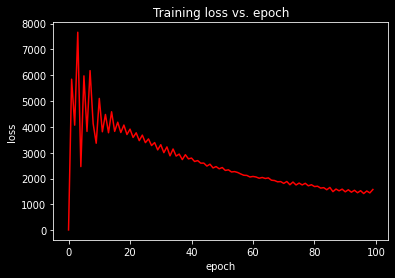

In [61]:
try:
    epoch_train(
        model=cifar10_model,
        data=cifar10_train.split(0.01),
        epochs=100,
        batch_size=500,
        progress=True
    )
except Exception as e:
    with np.printoptions(threshold=36):
        print(*[layer.input_shape for layer in cifar10_model.layers[1:]], sep='\n\n')
    print(e)

In [62]:
with np.printoptions(threshold=36):
    print(*cifar10_model.layers, sep='\n\n')

InputLayer(
	shape=(3072,),
	output=[[0.65 0.69 0.82 ... 0.29 0.30 0.29] 
	        [0.25 0.35 0.51 ... 0.10 0.18 0.25] 
	        [0.36 0.51 0.77 ... 0.14 0.15 0.20] 
	        ... 
	        [1.00 1.00 1.00 ... 0.68 0.47 0.73] 
	        [0.56 0.49 0.43 ... 0.48 0.48 0.63] 
	        [0.36 0.43 0.47 ... 0.29 0.26 0.24]])

DenseLayer(
	shape=(10,),
	input_shape=(3072,),
	activation=Identity,
	weights=[[16.54 26.46 28.93 ... 21.45 29.03 36.48] 
	         [25.43 25.29 33.06 ... 25.58 30.32 35.53] 
	         [34.96 29.15 21.77 ... 22.88 35.96 38.88] 
	         ... 
	         [11.73 26.99 24.68 ... 35.62 13.72 27.75] 
	         [14.86 25.49 25.97 ... 32.15 21.98 27.28] 
	         [19.12 26.08 15.27 ... 19.45 27.24 24.23]],
	biases=[[14.71 71.07 51.66 56.73 66.90 45.51 49.75 49.51 40.16 54.00]],
	output=[[39559.45 37857.62 36925.66 ... 38399.89 38752.44 38831.51] 
	        [39745.55 37075.28 36468.26 ... 37483.97 38275.16 37282.53] 
	        [33038.76 31614.07 29807.37 ... 31464.84 31813.33 3235

### 2.1.4. Verification

In [63]:
evaluator = ClassificationEvaluator(
    model=cifar10_model,
    data=cifar10_test.one_hot_decoded(),
    label_names=cifar10_label_names
)


Predicted label Airplane Automobile Bird Cat Deer Dog Frog Horse Ship Truck True label Airplane 217 51 566 0 1 35 0 0 125 5 Automobile 16 279 448 0 18 94 6 0 91 48 Bird 51 25 765 1 21 102 6 0 24 5 Cat 9 53 593 3 23 288 8 0 15 8 Deer 17 21 691 0 63 181 5 0 19 3 Dog 5 25 566 5 24 346 6 0 22 1 Frog 2 28 740 1 45 144 32 0 6 2 Horse 6 26 737 0 32 154 4 0 22 19 Ship 61 90 458 0 4 63 0 0 305 19 Truck 15 252 461 0 13 56 3 0 107 93 F1 scores 0.310 0.302 0.218 0.006 0.101 0.281 0.060 0.000 0.351 0.155 Accuracy 21.0%

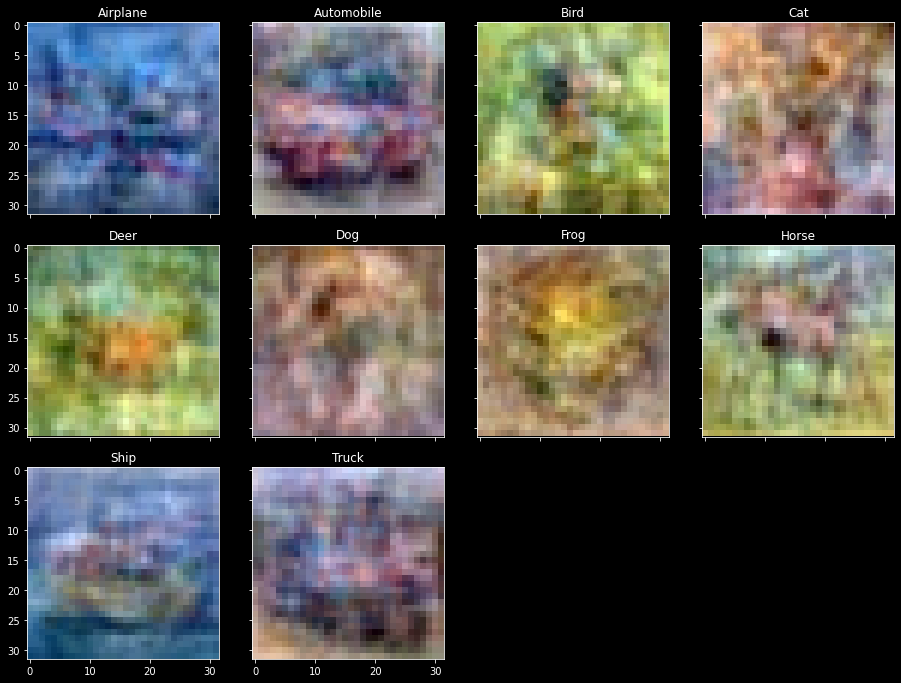

In [64]:
K = cifar10_model.layers[-1].shape[0]

fig, axs = plt.subplots(
    figsize=(12.8, 9.6),
    nrows=3, ncols=4,
    sharex=True, sharey=True,
    tight_layout=True
)

for ax, class_flat, label_name in zip(axs.ravel(), cifar10_model.layers[-1].weights.T, cifar10_label_names):
    class_img = class_flat.reshape(32, 32, 3)
    class_img -= class_img.min() #axis=(0,1)
    class_img /= class_img.max() #axis=(0,1)
    ax.set_title(label_name)
    ax.imshow(class_img)

for ax in axs.ravel()[K:]:
    fig.delaxes(ax)

## 2.2. Part (4b)

### 2.2.1 Zero-padding

In [ ]:
def zero_pad(X: NDArray, pad: int) -> NDArray:
    """Apply zero padding defined by the parameter pad on a single image (X) of the input data.
    
    Argument:
        X -- python numpy array of shape (H, W, C) representing one image
        pad -- integer, amount of padding around each image on vertical and horizontal
        dimensions

    Returns:
        X_pad -- padded image of shape (H + 2*pad, W + 2*pad, C)
    """

    assert X.ndim == 3, f'X {X.shape} must be an ndarray of shape (H, W, C)'

    new  = (X.shape[0] + 2*pad, X.shape[1] + 2*pad, X.shape[2])
    blit = (X.shape[0] +   pad, X.shape[1] +   pad)

    X_pad = cp.zeros(shape=new)
    X_pad[pad:blit[0], pad:blit[1], :] = X

    return X_pad

##
## TESTING
##

test_X = np.array([[[1]]]) # shape=(H, W, C)

test_X_pad = np.array([    # shape=(C, Hp, Wp) / after .transpose(): shape=(Hp, Wp, C)
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
]).transpose(1, 2, 0)

assert np.array_equal(zero_pad(test_X, pad=1), test_X_pad)

### 2.2.2. Convolution (forward pass)

In [ ]:
def conv_single_step(a_slice_prev: NDArray, W: NDArray, b: NDArray) -> NDArray:
    """Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation
    of the previous layer.

    Arguments:
        a_slice_prev -- slice of input data of shape (f, f, C_prev)
        W -- Weight parameters contained in a window - matrix of shape (f, f, C_prev)
        b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

    Returns:
        Z -- a scalar value, result of convolving the sliding window (W, on a slice x of the input data)
    """
    
    # Check input dimensions.
    assert a_slice_prev.ndim == 3, f'a_slice_prev {a_slice_prev.shape} must be an ndarray of shape (f, f, C_prev)'
    assert W.ndim == 3, f'W {W.shape} must be an ndarray of shape (f, f, C_prev)'
    assert a_slice_prev.shape == W.shape, f'a_slice_prev {a_slice_prev.shape} and W {W.shape} must have the same shape'
    assert b.shape == (1, 1, 1), f'b {b.shape} must be an ndarray of shape (1, 1, 1)'
    
    Z = (a_slice_prev * W).sum() + b
    
    return Z

##
## TESTING
##

test_a_slice_prev = np.array([ # shape=(f, f, C_prev)
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
]).T

test_W = np.array([            # shape=(f, f, C_prev)
    [[0, 0, 0],
     [0, 2, 0],
     [0, 0, 0]]
]).T

test_b = np.array([[[1]]])     # shape=(1, 1, 1)

test_Z = 3

assert conv_single_step(test_a_slice_prev, test_W, test_b) == test_Z

In [ ]:
def conv_forward(A_prev: NDArray, W: NDArray, b: NDArray, hparams: Dict[str, Any]) -> Tuple[NDArray, Dict[str, Any]]:
    """Implements the forward propagation for a convolution function

    Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        W -- Weights, numpy array of shape (f, f, C_prev, C)
        b -- Biases, numpy array of shape (1, 1, 1, C)
        hparams -- python dictionary containing "stride" and "pad"
    Returns:
        Z -- conv output, numpy array of shape (m, H, W, C)
        mem -- cache of values needed for the conv_backward() function
    """
    
    # Check input dimensions.
    assert A_prev.ndim == 4, f'A_prev {A_prev.shape} must be an ndarray of shape (m, H_prev, W_prev, C_prev)'
    assert W.ndim == 4, f'W {W.shape} must be an ndarray of shape (f, f, C_prev, C)'
    assert b.ndim == 4 and b.shape[:3] == (1, 1, 1), f'b {b.shape} must be an ndarray of shape (1, 1, 1, C)'
    assert A_prev.shape[3] == W.shape[2], f'A_prev {A_prev.shape} and W {W.shape} must have the same number of previous channels (C_prev)'
    assert W.shape[3] == b.shape[3], f'W {W.shape} and b {b.shape} must have the same number of channels (C)'
    valid_keys = ('stride', 'pad')
    assert all(key in hparams for key in valid_keys), f'hparams must be a dict with the keys: {" ".join(valid_keys)}'

    stride, pad = hparams['stride'], hparams['pad']
    
    m = A_prev.shape[0]
    f = W.shape[0]
    C = W.shape[3]
    
    Z = None
    
    # Iterate over each channel
    for c in range(C):
        W_slice = W[:, :, :, c]
        b_slice = b[:, :, :, c]
        
        # Iterate over each sample
        for i, a_prev in enumerate(A_prev):
            a_pad = zero_pad(a_prev, pad)
        
            Hp, Wp = a_pad.shape[0:2]
            Hf, Wf = Hp-f, Wp-f
            Hs, Ws = (Hf//stride)+1, (Wf//stride)+1
        
            if Z is None:
                Z = cp.zeros((m, Hs, Ws, C))
            
            idx = cp.mgrid[:(Hf+1):stride, :(Wf+1):stride].T.reshape(-1, 2)
        
            # Iterate over each slice position
            for ij in idx:
                a_slice = a_pad[ij[0]:ij[0]+f, ij[1]:ij[1]+f]
                Z[i, ij[0], ij[1], c] = conv_single_step(a_slice, W_slice, b_slice)
    
    return Z, {'A_prev': A_prev, 'W': W, 'b': b, **hparams}

##
## TESTING
##

test_A_prev = np.array([[[[1]]]]) # shape=(m, H_prev, W_prev, C_prev)

test_W = np.array([[              # shape=(C_prev, C, f, f) / after .transpose(): shape=(f, f, C_prev, C)
    [[0, 0, 0],
     [0, 2, 0],
     [0, 0, 0]],
    [[0, 0, 0],
     [0, 3, 0],
     [0, 0, 0]],
]]).transpose(2, 3, 0, 1)

test_b = np.array([[[[0, 0]]]])   # shape=(1, 1, 1, C)

test_Z = np.array([[              # shape=(m, C, H, W) / after .transpose(): shape=(m, H, W, C)
    [[2]],
    [[3]]
]]).transpose(0, 2, 3, 1)

actual_Z = conv_forward(test_A_prev, test_W, test_b, {'stride': 1, 'pad': 1})[0]

print(f'Exp. Z={test_Z.transpose(0, 3, 1, 2)}')
print(f'Act. Z={actual_Z.transpose(0, 3, 1, 2)}')

assert cp.array_equal(actual_Z, test_Z)

### 2.2.3. Pooling (forward pass)

In [ ]:
def pool_forward(A_prev: NDArray, hparams: Dict[str, Any], mode: str) -> Tuple[NDArray, Dict[str, Any]]:
    """Implements the forward pass of the pooling layer

    Arguments:
        A_prev -- Input data, numpy array of shape (m, H_prev, W_prev, C)
        hparams -- python dictionary containing "f" and "stride"

    Returns:
        A -- output of the pool layer, a numpy array of shape (m, H, W, C)
        mem -- cache used in the backward pass of the pooling layer, contains the input and
        hparams
    """
    
    # Check input dimensions.
    assert A_prev.ndim == 4, f'A_prev {A_prev.shape} must be an ndarray of shape (m, H_prev, W_prev, C)'
    valid_keys = ('f', 'stride')
    valid_modes = ('max', 'average')
    assert all(key in hparams for key in valid_keys), f'hparams must be a dict with the keys: {" ".join(valid_keys)}'
    assert mode in valid_modes, f'mode must be one of the following: {" ".join(valid_modes)}'

    # Unpack hyperparameters.
    f, stride = hparams['f'], hparams['stride']
    
    m, H, W, C = A_prev.shape
    Hf, Wf = H-f, W-f
    Hs, Ws = Hf//stride + 1, Wf//stride + 1
    
    A_pool = cp.zeros((m, Hs, Ws, C))
    a_pool = cp.zeros((f, f, Hs, Ws, C))
    idx = cp.mgrid[:f, :f].T.reshape(-1, 2)
    
    # Iterate over each sample
    for i, a_prev in enumerate(A_prev):
        # Iterate over each slice position
        for ij in idx:
            a_pool[tuple(ij)] = a_prev[ij[0]::stride, ij[1]::stride] 

        # Perform max/avg pooling
        if mode == 'max':
            A_pool[i] = a_pool.max(axis=(0,1))
        else: # if mode == 'average':
            A_pool[i] = a_pool.mean(axis=(0,1))
        
    return A_pool, { 'A_prev': A_prev, **hparams }


##
## TESTING
##

test_A_prev = np.array([[ # shape=(m, C_prev, H_prev, W_prev) / after .transpose(): shape=(m, H_prev, W_prev, C_prev)
    [[1, 2, 3, 4],
     [5, 4, 3, 2]]
]]).transpose(0, 2, 3, 1)

test_A = np.array([[      # shape=(m, C, H, W) / after .transpose(): shape=(m, H, W, C)
    [[5, 4]]
]]).transpose(0, 2, 3, 1)

actual_A = pool_forward(test_A_prev, {'f': 2, 'stride': 2}, 'max')[0]

print(f'Exp. A={test_A.transpose(3, 0, 1, 2)}')
print(f'Act. A={actual_A.transpose(3, 0, 1, 2)}')

assert cp.array_equal(actual_A, test_A)

### 2.2.4. Convolution (backward pass)

***FIXME:** This function does not perform zero-padding on activation maps properly and therefore causes to errors.*

In [ ]:
def conv_backward(dZ: NDArray, mem: Dict[str, Any]) -> Tuple[NDArray, NDArray, NDArray]:
    """Implement the backward propagation for a convolution function

    Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of
        shape (m, H, W, C)
        mem -- cache of values needed for the conv_backward(), output of conv_forward()

    Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
        numpy array of shape (m, H_prev, W_prev, C_prev)
        dW -- gradient of the cost with respect to the weights of the conv layer (W)
        numpy array of shape (f, f, C_prev, C)
        db -- gradient of the cost with respect to the biases of the conv layer (b)
        numpy array of shape (1, 1, 1, C)
    
    Reference:
        Jong-Chyi Su, 2018. "Forward and Backward Pass of Convolutional layers"
        URL: https://compsci682-sp18.github.io/docs/conv2d_discuss.pdf
        
        Jefkine Kafunah, 2016. "Backpropagation In Convolutional Neural Networks"
        URL: https://jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/
        
        Pavitra Solai, 2018. "Convolutions and Backpropagations"
        URL: https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c
    
    Issues:
        - No support for filter stride.
    """

    # Check input dimensions.    
    assert dZ.ndim == 4, f'dZ {dZ.shape} must be an ndarray of shape (m, H, W, C)'
    valid_keys = ('A_prev', 'W', 'b')
    assert all(key in mem for key in valid_keys), f'mem must be a dict with the keys: {" ".join(valid_keys)}'
    
    # Unpack memory.
    A_prev, W, b, Z = mem['A_prev'], mem['W'], mem['b'], mem['Z']
    f, stride = mem['f'], mem['stride']

    Ha, Wa = A_prev.shape[1:3] 
    m, Hz, Wz, C = dZ.shape
    C_prev = W.shape[2]
    
    dA_prev = cp.zeros_like(A_prev)
    dW = cp.zeros_like(W)
    db = cp.zeros_like(b)
    

    # Iterate over each channel
    for c in range(C):
        W_flip = cp.flip(W[..., c], axis=(0, 1)) # rotate filter by 180deg
        W_pad = zero_pad(W_flip, Hz-1)           # zero pad for full convolution with dZ
        
        # Iterate over each sample
        for k, (a_prev, dz) in enumerate(zip(A_prev, dZ)):
            for i, j, c in cp.ndindex(dz.shape):
                a_slice = a_prev[i:i+f, j:j+f, :]
                w_slice = W_pad[i:i+Hz, j:j+Wz, :]

                # Perform full convolution on flipped filter for dL/dX = W' ⊛ dZ
                dA_prev[i:i+f, j:j+f, :] += w_slice * dz[i, j, c]
                
                # Perform convolution on filter for dL/dW = X ⁕ dZ
                dW[..., c] += a_slice * dz[i, j, c]

    
    # Perform sum on gradient for dL/db = 1 ∙ dZ.
    db = dZ.sum(axis=(0, 1, 2), keepdims=True)

    # Check output dimensions.
    assert dA_prev.shape == A_prev.shape, f'dA_prev {dA_prev.shape} must match the shape of A_prev {A_prev.shape}'
    assert dW.shape == W.shape, f'dW {dW.shape} must match the shape of W {W.shape}'
    assert db.shape == b.shape, f'db {db.shape} must match the shape of b {b.shape}'

    return dA_prev, dW, db

##
## TESTING
##

## @todo: add unit test

### 2.2.5. Pooling (backward pass)

In [ ]:
def create_mask_from_window(x: NDArray) -> NDArray:
    """Creates a mask from an input matrix x, to identify the max entry of x.

    Arguments:
        x -- Array of shape (f, f)
    Returns:
        mask -- Array of the same shape as window, contains a True at the position corresponding
        to the max entry of x.
    """

    # Check input dimensions.
    assert x.ndim == 2, f'x {x.shape} must be an ndarray of shape (f, f)'
    
    # Compute mask.
    mask = cp.zeros_like(x, dtype=cp.bool_)
    idx = cp.argmax(x, axis=None)
    mask[cp.unravel_index(idx, x.shape)] = True
    
    return mask

##
## TESTING
##

test_x = cp.array(    # shape=(f, f)
    [[1, 2],
     [3, 4]]
)

test_mask = cp.array( # shape=(f, f)
    [[False, False],
     [False, True]],
)

actual_mask = create_mask_from_window(test_x)

print(f'Exp. mask={test_mask}')
print(f'Act. mask={actual_mask}')

assert cp.array_equal(actual_mask, test_mask)


In [ ]:
def pool_backward(dA: NDArray, mem: Dict[str, Any], mode: str) -> NDArray:
    """Implements the backward pass of the pooling layer.

    Arguments:
        dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
        mem -- cache output from the forward pass of the pooling layer, contains the layer's input
        and hparams
        mode -- the pooling mode you would like to use, defined as a string ("max" or "average")    

    Returns:
        dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as
        A_prev
    """
    
    # Check input dimensions.
    valid_keys = ('f', 'stride', 'A_prev')
    valid_modes = ('max', 'average')
    assert all(key in mem for key in valid_keys), f'mem must be a dict with the keys: {" ".join(valid_keys)}'
    assert mode in valid_modes, f'mode must be one of the following: {" ".join(valid_modes)}'
    
    # Unpack memory.
    f, stride = mem['f'], mem['stride']
    A_prev = mem['A_prev'] # shape=(m, H_prev, W_prev, C_prev)
    
    m, Hs, Ws, C = dA.shape
    Hf, Wf = (Hs-1)*stride, (Ws-1)*stride
    H_prev, W_prev = Hf+f, Wf+f
    
    dA_prev = cp.zeros((m, H_prev, W_prev, C))
    
    idx = cp.ndindex(Hs, Ws)
    idx_prev = cp.mgrid[:H_prev:stride, :W_prev:stride].T.reshape(-1, 2)
    
    # Iterate over each channel.
    for c in range(C):
        # Iterate over each sample.    
        for i in range(m):
            for ij, ij_prev in zip(idx, idx_prev):
                a_slice_prev = A_prev[
                    i,
                    ij_prev[0]:ij_prev[0]+f,
                    ij_prev[1]:ij_prev[1]+f,
                    c
                ]
                
                if mode == 'max':
                    mask = create_mask_from_window(a_slice_prev)
                    dA_prev[
                        i,
                        ij_prev[0]:ij_prev[0]+f,
                        ij_prev[1]:ij_prev[1]+f,
                        c
                    ] = cp.where(mask, dA[i, ij[0], ij[1], c], 0)
                else: # if mode == 'average':
                    dA_prev[
                        i,
                        ij_prev[0]:ij_prev[0]+f,
                        ij_prev[1]:ij_prev[1]+f,
                        c
                    ] = dA[i, ij[0], ij[1], c] / (f * f)

    return dA_prev

##
## TESTING
##

test_A_prev = np.array([[  # shape=(m, C_prev, H_prev, W_prev) / after .transpose(): shape=(m, H_prev, W_prev, C_prev)
    [[1, 2, 3, 4],
     [5, 4, 3, 2]]
]]).transpose(0, 2, 3, 1)

test_dA = np.array([[      # shape=(m, C, H, W) / after .transpose(): shape=(m, H, W, C)
    [[2, 1]]
]]).transpose(0, 2, 3, 1)

test_dA_prev = np.array([[ 
    [[0, 0, 0, 1],
     [2, 0, 0, 0]]
]]).transpose(0, 2, 3, 1)

actual_dA_prev = pool_backward(test_dA, {'f': 2, 'stride': 2, 'A_prev': test_A_prev}, 'max')

print(f'Exp. dA_prev={test_dA_prev.transpose(3, 0, 1, 2)}')
print(f'Act. dA_prev={actual_dA_prev.transpose(3, 0, 1, 2)}')

assert cp.array_equal(actual_dA_prev, test_dA_prev)

### 2.2.6. Convolution Layer

In [ ]:
@dataclass(repr=False)
class Conv2DLayer(Layer):
    channel_size: int
    filter_size: Optional[int] = field(default=3)
    filter_stride: Optional[int] = field(default=1)
    input_shape: Optional[Tuple[int]] = field(default=None)
    activation: Activation.Base = field(default_factory=Activation.Identity) 
    weights: Optional[NDArray] = field(default=None)
    biases: Optional[NDArray] = field(default=None)
    output: Optional[NDArray] = field(default=None)


    def forward(self, x: NDArray) -> NDArray:
        if self.weights is None or self.biases is None:
            raise RuntimeError('cannot feedforward with uninitialized weights or biases')
        
        self.output, _ = conv_forward(x, self.weights, self.biases, {
            'pad': (self.filter_size - 1) // 2,
            'stride': self.filter_stride,
        })
        
        # Return the output value.
        return self.output


    def backward(self, x: NDArray, upstream_grad: NDArray, optimizer: Optimizer.Base) -> NDArray:
        if self.output is None:
            raise RuntimeError('cannot backpropagate errors without feedforward output data')

        x_grad, W_grad, b_grad = conv_backward(upstream_grad, {
            'A_prev': x,
            'W': self.weights,
            'b': self.biases,
            'Z': self.output,
            'f': self.filter_size,
            'stride': self.filter_stride
        })
        
        # Maintain expected dimensions.
        assert b_grad.shape == self.biases.shape,  f'bias shape {self.biases.shape} and bias gradient shape {b_grad.shape} do not match'
        assert W_grad.shape == self.weights.shape, f'weight shape {self.weights.shape} and weight gradient shape {W_grad.shape} do not match'
        assert x_grad.shape == x.shape,            f'input shape {x.shape} and input gradient shape {x_grad.shape} do not match'

        # Update the model parameters using the optimizer function, given the current states and gradients.
        self.weights, self.biases = optimizer([self.weights, self.biases], [W_grad, b_grad])

        # Return the downstream gradient, dL/dx.
        return x_grad
    
    
    def get_parameter_shape(self) -> Tuple[Tuple[int], Tuple[int]]:
        if len(self.input_shape) == 1: # test if previous layer was FC layer.
            prev_channel_size = self.input_shape[0]
        elif len(self.input_shape) == 3: # test if previous layer was convolutional layer.
            prev_channel_size = self.input_shape[2]
        
        weights_shape = (self.filter_size, self.filter_size, prev_channel_size, self.channel_size)
        biases_shape = (1, 1, 1, self.channel_size)
        
        return weights_shape, biases_shape
        
    def get_output_shape(self) -> Tuple[int]:
        H, W, C = self.input_shape
        f, s = self.filter_size, self.filter_stride
        return (H//s, W//s, self.channel_size)


### 2.2.7. Pooling Layer

In [ ]:
@dataclass(repr=False)
class Pool2DLayer(Layer):
    channel_size: int
    filter_size: Optional[int] = field(default=2)
    filter_stride: Optional[int] = field(default=2)
    mode: str = field(default='max') # or 'average'
    input_shape: Optional[Tuple[int]] = field(default=None)
    output: Optional[NDArray] = field(default=None)


    def forward(self, x: NDArray) -> NDArray:
        self.output, _ = pool_forward(x,
            {
                'f': self.filter_size,
                'stride': self.filter_stride
            },
            self.mode
        )
        
        # Return the output value.
        return self.output


    def backward(self, x: NDArray, upstream_grad: NDArray, optimizer: Optimizer.Base) -> NDArray:
        if self.output is None:
            raise RuntimeError('cannot backpropagate errors without feedforward output data')

        x_grad = pool_backward(
            upstream_grad,
            {
                'A_prev': x,
                'f': self.filter_size,
                'stride': self.filter_stride
            },
            self.mode
        )
        
        # Maintain expected dimensions.
        assert x_grad.shape == x.shape, f'input shape {x.shape} and input gradient shape {x_grad.shape} do not match'

        # Return the downstream gradient, dL/dx.
        return x_grad
    
    def get_parameter_shape(self) -> Tuple[Tuple[int], Tuple[int]]:
        return (), ()
        
    def get_output_shape(self) -> Tuple[int]:
        H, W, C = self.input_shape
        f, s = self.filter_size, self.filter_stride
        return ((H-f)//s + 1, (W-f)//s + 1, C) # @note: check formula


### 2.2.8. Model selection

In [ ]:
cifar10_model = NeuralNetwork(
    layers=[
        InputLayer(shape=(32, 32, 3)),
        Conv2DLayer(channel_size=6, filter_size=3, filter_stride=1),
        Pool2DLayer(channel_size=3, filter_size=2, filter_stride=2, mode='max'),
        DenseLayer(shape=cifar10_train.n_labels)
    ],
    initializer=Initializer.HeNormal(rng=rng),
    optimizer=Optimizer.GradientDescent(learning_rate=0.5),
    loss=Loss.NegativeLogLikelihood(),
    classifier=Classifier.Argmax()
)

In [ ]:
epoch_train(
    model=cifar10_model,
    data=cifar10_train.split(0.01),
    epochs=100,
    batch_size=50,
    progress=True
)

In [ ]:
with np.printoptions(threshold=36):
    print(*cifar10_model.layers, sep='\n\n')